In [3]:
import test_visualization as tv

In [4]:
import tensorflow as tf
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
tf.__version__
path = "../../"
model_path = path + "models/"
test_path = path + "data/test/"
model_path_cull = model_path + "cull%i/" % 1
sys.path.insert(0, model_path + "model_functions")
sys.path.insert(0, path + "preprocess")

import primary_model as pm
import fasta_to_1_hot_encodings as fthe
import get_contact_maps as gcm

model = tf.keras.models.load_model(
    model_path_cull + 'my_model.h5',
    custom_objects={"OuterProduct2": pm.OuterProduct2()}
)

fasta_seq_path = test_path + "casp11.fasta"
pdb_path = test_path + "casp11.targets_refine/"

fasta_seqs = fthe.convert_fasta_to_1_hot(
    fasta_seq_path,
    train=False
)

c_maps = gcm.get_contact_maps(
    pdb_path,
    train=False
)

# plot_contact_maps(model, fasta_seqs, c_maps)

PDB File:  TR217.pdb
PDB File:  TR228.pdb
PDB File:  TR274.pdb
PDB File:  TR280.pdb
PDB File:  TR283.pdb
PDB File:  TR759.pdb
PDB File:  TR760.pdb
PDB File:  TR762.pdb
PDB File:  TR765.pdb
PDB File:  TR768.pdb
PDB File:  TR769.pdb
PDB File:  TR772.pdb
PDB File:  TR774.pdb
PDB File:  TR776.pdb
PDB File:  TR780.pdb
PDB File:  TR782.pdb
PDB File:  TR783.pdb
PDB File:  TR786.pdb
PDB File:  TR792.pdb
PDB File:  TR795.pdb
PDB File:  TR803.pdb
PDB File:  TR810.pdb
PDB File:  TR811.pdb
PDB File:  TR816.pdb
PDB File:  TR817.pdb
PDB File:  TR821.pdb
PDB File:  TR822.pdb
PDB File:  TR823.pdb
PDB File:  TR827.pdb
PDB File:  TR828.pdb
PDB File:  TR829.pdb
PDB File:  TR833.pdb
PDB File:  TR837.pdb
PDB File:  TR848.pdb
PDB File:  TR854.pdb
PDB File:  TR856.pdb
PDB File:  TR857.pdb


In [3]:
c_maps

{'TR217': array([[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'TR228': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 'TR274': array([[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True, Fa

In [33]:
pdb_id = 'TR854'
one_hot = fasta_seqs[pdb_id]
one_hot = one_hot.reshape((1,) + one_hot.shape)
c_map_pred = model.predict(one_hot)

c_map_pred = c_map_pred.reshape(c_map_pred.shape[1:])

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, None, 20)     0                                            
__________________________________________________________________________________________________
1d_convnet_layer1a (Conv1D)     (None, None, 20)     6820        input_layer[0][0]                
__________________________________________________________________________________________________
1d_convnet_batch_norm1a (BatchN (None, None, 20)     80          1d_convnet_layer1a[0][0]         
__________________________________________________________________________________________________
1d_convnet_layer1b (Conv1D)     (None, None, 20)     6820        1d_convnet_batch_norm1a[0][0]    
__________________________________________________________________________________________________
1d_convnet

In [34]:
c_map_pred

array([[0.1237931],
       [0.1237931],
       [0.1237931],
       ...,
       [0.1237931],
       [0.1237931],
       [0.1237931]], dtype=float32)

In [12]:
from math import sqrt
c_map_pred_shape = int (sqrt (c_map_pred.shape[0]))
reshaped = c_map_pred.reshape((c_map_pred_shape, c_map_pred_shape))#.shape

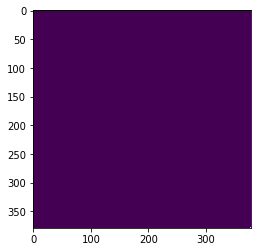

In [15]:
plt.imshow(reshaped)
plt.show()

In [30]:
# reshaped
id1 = 'TR280'
print (np.count_nonzero (c_maps[id1]))
print(c_maps[id1].shape[0] * c_maps[id1].shape[1])

1000
9216


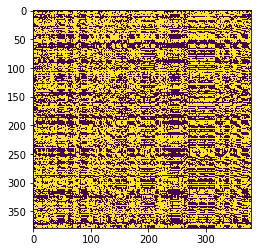

In [9]:
plt.imshow(c_map_pred[:, :, 0] - c_map_pred[:, :, 1] > 0.5)
plt.show()

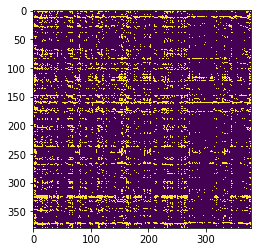

In [17]:
# np.argmax(c_map_pred, axis=-1)
# plt.imshow (c_map_pred[:, :, 0] > c_map_pred[:, :, 1])
# plt.imshow(np.argmax(c_map_pred, axis=-1))
plt.show()

In [37]:
c_map_pred[:, :, 0].shape

(379, 379)

In [23]:
np.count_nonzero (c_map_pred[:, :, 1] > 0.5)

68138

In [45]:
"""
CONFOLD server requires:
E-mail Address
Job Id
Sequence
Secondary Structure
Contacts
"""


def contacts_in_RR_format(pdb_id, contact_map, sequence, sec_structure, threshold=8):
    """
    Convert the contact map matrix into the RR format.

    Format is:

    i  j  d1  d2  p

    i, j are the indices of the residues in contact.
    i < j (since the matrix is symmetrical)

    d1 and d2 indicates the threshold for contact.
    d1 = 0, d2 = 8 Angstrom is the norm.

    p indicates the probability of the two residues 
    in contact. (0.0-1.0)
    Contacts should be listed in decreasing order

    Any pair not listed is considered to not be in contact

    See here for more information:
    http://predictioncenter.org/casp13/index.cgi?page=format

    :param pdb_id: pdb id
    :type  pdb_id: str
    :param contact_map: contact matrix
    :type  contact_map: numpy array
    :param sequence: one letter aa sequence
    :type  sequence: str 
    :param sec_structure: one letter secondary structure
    :type  sec_structure: str
    :param threshold: threshold of contact
    :param threshold: int
    :returns: a string in the correct format
    :rtype:   str
    """

    df = pd.DataFrame(contact_map)

    columns = df.columns

    contacts = {}
    for index, row in df.iterrows():
        for col_num, col in enumerate(columns):
            prob = row[col]
            if prob > 0.5:
                min1 = min(index, col_num)
                max1 = max(index, col_num)
                contacts[str(min1) + ' ' + str(max1)] = prob
#                 contacts.append((index, col_num, prob))

    contact_str = "Sequence: \n%s\n\n\n" % sequence
    contact_str += "Secondary Structure: \n%s\n\n\n" % sec_structure
    contact_str += "Residues in Contact:\n"

    for resids, prob in contacts.items():
        contact_str += resids + " " + str(prob) + '\n'
#     return contacts

    return contact_str


x = contacts_in_RR_format("AAAA", c_map_pred[:, :, 1][:5, :5], "AAAA", "BBBB")

In [46]:
print (x)

Sequence: 
AAAA


Secondary Structure: 
BBBB


Residues in Contact:
0 0 10.917419
0 1 9.447587
0 2 5.150753
0 3 1.4173317
0 4 2.670597
1 1 8.65955
1 2 5.712083
1 3 8.800732
1 4 9.907942
2 2 8.1895685
2 3 1.4162312
2 4 9.609776
3 3 3.6729276
3 4 8.167943
4 4 1.8101193



In [24]:
import pandas as pd

# pd.DataFrame(c_map_pred[:, :, 1])
min(3,4)

3

In [28]:
a = np.symmetric((3,3))

AttributeError: module 'numpy' has no attribute 'symmetric'